In [1]:
import data_bert
import model_bert_evaluation_pipeline
import model_bert_tree_evaluation_pipeline
import model_bert_evaluation_helpers
import config
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
topics = data_bert.topics
topics_inv_map = pd.Series(data=np.arange(len(topics)), index=topics.index)
topic_trees = []
total_nodes = []
total_nodes_by_tid = np.empty(shape = len(topics), dtype="object")
for str_id in topics.loc[topics["level"] == 0].index:
    node = model_bert_tree_evaluation_pipeline.Node(level=0, topic_num_id=topics_inv_map[str_id], topic_str_id=str_id)
    topic_trees.append(node)
    total_nodes.append(node)
    total_nodes_by_tid[topics_inv_map[str_id]] = node

# generate tree structure
for level in range(np.max(topics["level"].unique())):
    for str_id in topics.loc[topics["level"] == (level + 1)].index:
        parent = model_bert_tree_evaluation_pipeline.find_node_by_str_id(total_nodes, topics.loc[str_id, "parent"])

        node = model_bert_tree_evaluation_pipeline.Node(level=(level+1), topic_num_id=topics_inv_map[str_id], topic_str_id=str_id)
        node.parent = parent
        parent.children.append(node)

        total_nodes.append(node)
        total_nodes_by_tid[node.topic_num_id] = node

topic_id_to_preorder_id = np.zeros(shape=len(total_nodes), dtype=np.int32)
topic_id_to_subtree_end = np.zeros(shape=len(total_nodes), dtype=np.int32)
preorder_id_to_topic_id = np.zeros(shape=len(total_nodes), dtype=np.int32)

cur_id = 0
for node in topic_trees:
    cur_id = model_bert_tree_evaluation_pipeline.compute_preorder_id(node, cur_id, topic_id_to_preorder_id, preorder_id_to_topic_id, topic_id_to_subtree_end) + 1

In [3]:
def compute_expanded_tree(node, min_subtree_size):
    for child in node.children:
        compute_expanded_tree(child, min_subtree_size)
    
    if node.subtree_end_id - node.preorder_id < min_subtree_size:
        cnode = node
        while cnode.parent is not None:
            cnode = cnode.parent
            if cnode.subtree_end_id - cnode.preorder_id >= min_subtree_size:
                break
        node.least_subtree = cnode
    else:
        node.least_subtree = node

In [4]:
mapping_dict = {}
for min_expand in range(1,30):
    for node in topic_trees:
        compute_expanded_tree(node, min_expand)
    mapping = np.zeros(shape = len(data_bert.topics), dtype=np.int32)
    for k in range(len(data_bert.topics)):
        topic_str_id = data_bert.topics.index[k]
        node = total_nodes_by_tid[k]
        mapping[k] = node.least_subtree.topic_num_id
    mapping_dict[min_expand] = mapping

Computed metrics of 0 out of 25338
0.12497138977050781
Computed metrics of 200 out of 25338
12.405163526535034
Computed metrics of 400 out of 25338
3.9391329288482666
Computed metrics of 600 out of 25338
5.620434522628784
Computed metrics of 800 out of 25338
6.052021503448486
Computed metrics of 1000 out of 25338
3.9104115962982178
Computed metrics of 1200 out of 25338
3.488313674926758
Computed metrics of 1400 out of 25338
4.355833530426025
Computed metrics of 1600 out of 25338
3.5385265350341797
Computed metrics of 1800 out of 25338
9.787885665893555
Computed metrics of 2000 out of 25338
8.337280750274658
Computed metrics of 2200 out of 25338
5.484597444534302
Computed metrics of 2400 out of 25338
3.830387592315674
Computed metrics of 2600 out of 25338
15.043943643569946
Computed metrics of 2800 out of 25338
3.785764694213867
Computed metrics of 3000 out of 25338
3.4719104766845703
Computed metrics of 3200 out of 25338
3.4791626930236816
Computed metrics of 3400 out of 25338
4.484764

,mean_recall,mean_precision,mean_accuracy,mean_f2,final_recall,final_precision,final_f2,final_accuracy,restriction_ratio
1,0.915248,0.002915,0.948860,0.013781,0.882776,0.001202,0.005977,0.948860,0.051194
2,0.975168,0.000991,0.890939,0.004886,0.968176,0.000618,0.003084,0.890939,0.109126
3,0.977439,0.000928,0.882305,0.004586,0.971355,0.000575,0.002868,0.882305,0.117761
4,0.979714,0.000868,0.869105,0.004294,0.974605,0.000519,0.002588,0.869105,0.130961
5,0.981955,0.000790,0.849979,0.003913,0.978360,0.000454,0.002267,0.849979,0.150088
6,0.983710,0.000718,0.832873,0.003556,0.980843,0.000409,0.002041,0.832873,0.167194
7,0.985162,0.000655,0.816168,0.003246,0.982498,0.000372,0.001859,0.816168,0.183899
8,0.986584,0.000604,0.801143,0.002995,0.984254,0.000345,0.001722,0.801143,0.198925
9,0.987521,0.000564,0.789654,0.002796,0.985405,0.000326,0.001630,0.789654,0.210413
10,0.988359,0.000526,0.776592,0.002610,0.986515,0.000308,0.001536,0.776592,0.223476


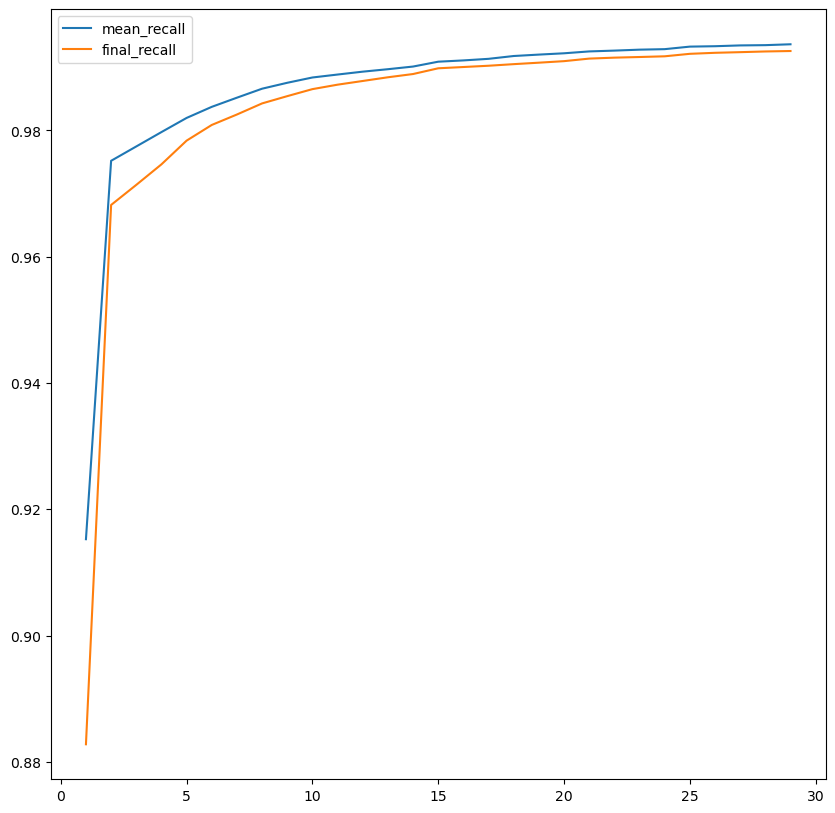

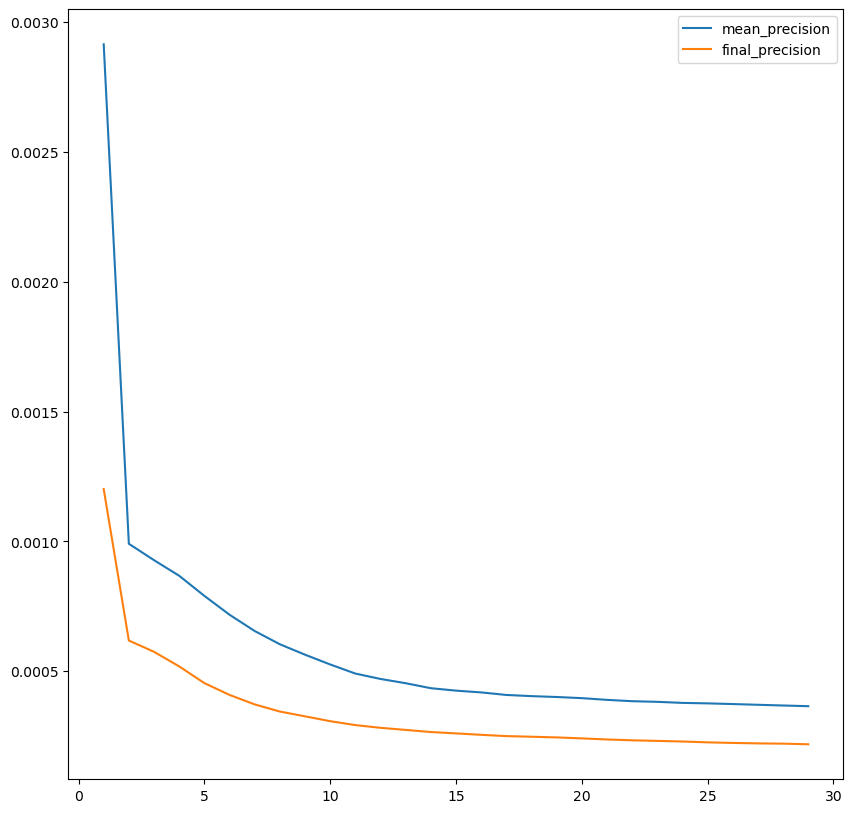

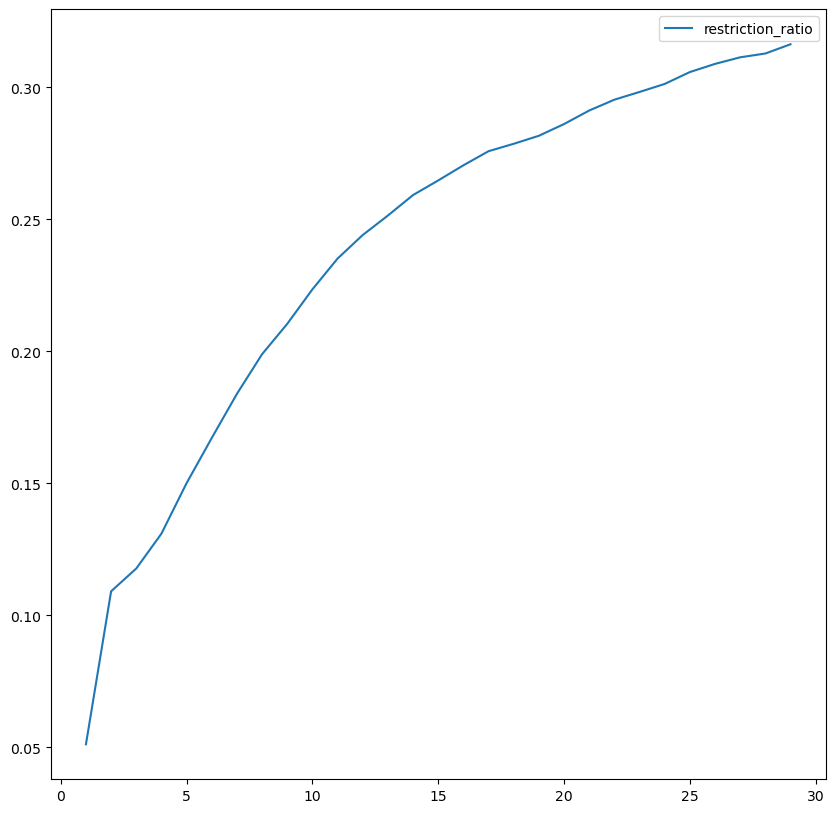

In [5]:
folder = config.resources_path + "model_eval_tree/" + "precise_best_in_test/"
cors_arr = np.empty(shape = len(topics), dtype = "object")
for k in range(len(topics)):
    if os.path.isfile(folder + str(k) + ".npy"):
        row_preds = set(list(np.load(folder + str(k) + ".npy")))
    else:
        row_preds = set()
    cors_arr[k] = row_preds

dframe = model_bert_evaluation_helpers.evaluate_quality_from_cors_arr(mapping_dict, data_bert.test_topics_num_id,
                                                                   data_bert.test_contents_num_id, cors_arr)
display(dframe)
dframe[["mean_recall", "final_recall"]].plot(figsize = (10, 10))
plt.show()
dframe[["mean_precision", "final_precision"]].plot(figsize = (10, 10))
plt.show()
dframe[["restriction_ratio"]].plot(figsize = (10, 10))
plt.show()

Computed metrics of 0 out of 25338
0.06251811981201172
Computed metrics of 200 out of 25338
4.397728443145752
Computed metrics of 400 out of 25338
3.0213730335235596
Computed metrics of 600 out of 25338
4.50505256652832
Computed metrics of 800 out of 25338
3.195732831954956
Computed metrics of 1000 out of 25338
3.22527813911438
Computed metrics of 1200 out of 25338
3.3639721870422363
Computed metrics of 1400 out of 25338
2.951744318008423
Computed metrics of 1600 out of 25338
3.1647353172302246
Computed metrics of 1800 out of 25338
3.0774002075195312
Computed metrics of 2000 out of 25338
3.07071852684021
Computed metrics of 2200 out of 25338
3.8843793869018555
Computed metrics of 2400 out of 25338
3.1017236709594727
Computed metrics of 2600 out of 25338
3.263253688812256
Computed metrics of 2800 out of 25338
4.545351505279541
Computed metrics of 3000 out of 25338
3.6906607151031494
Computed metrics of 3200 out of 25338
3.1315908432006836
Computed metrics of 3400 out of 25338
3.69044518

,mean_recall,mean_precision,mean_accuracy,mean_f2,final_recall,final_precision,final_f2,final_accuracy,restriction_ratio
1,0.829375,0.014966,0.976053,0.051202,0.763856,0.002220,0.010972,0.976053,0.023984
2,0.930097,0.002779,0.944840,0.012947,0.904295,0.001141,0.005679,0.944840,0.055217
3,0.933291,0.002459,0.940178,0.011738,0.909503,0.001059,0.005269,0.940178,0.059879
4,0.937189,0.002204,0.933067,0.010591,0.915670,0.000953,0.004744,0.933067,0.066991
5,0.942038,0.001917,0.922336,0.009279,0.923129,0.000828,0.004124,0.922336,0.077723
6,0.945715,0.001656,0.913607,0.008068,0.928761,0.000749,0.003732,0.913607,0.086452
7,0.949074,0.001477,0.904466,0.007214,0.933263,0.000680,0.003392,0.904466,0.095594
8,0.952398,0.001299,0.895992,0.006371,0.937159,0.000628,0.003130,0.895992,0.104069
9,0.954644,0.001198,0.889878,0.005883,0.940661,0.000595,0.002968,0.889878,0.110183
10,0.956956,0.001082,0.882294,0.005325,0.944658,0.000559,0.002789,0.882294,0.117768


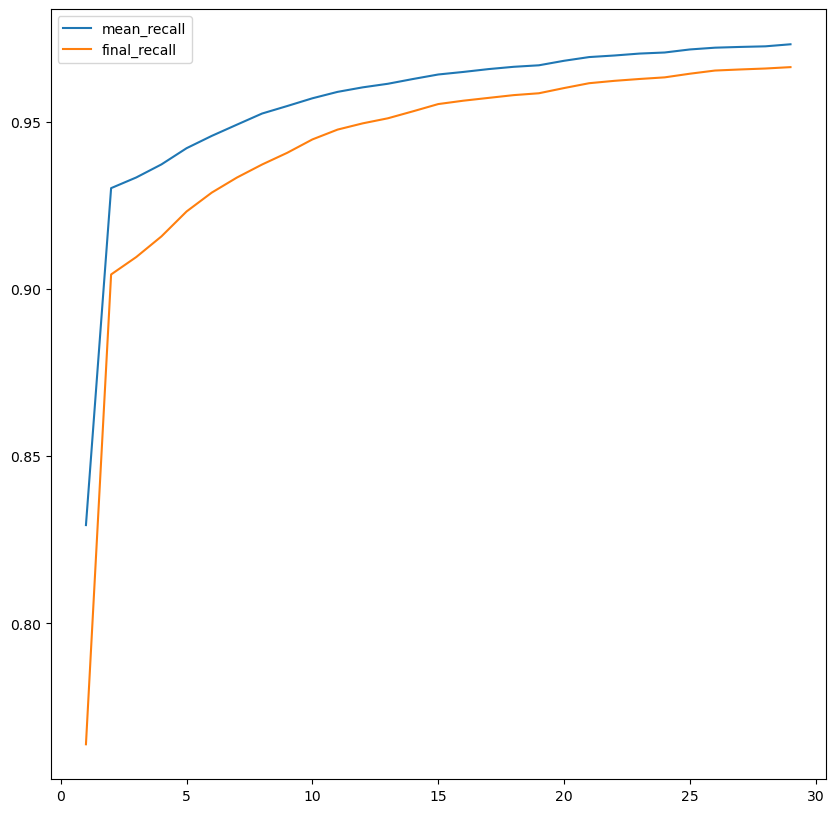

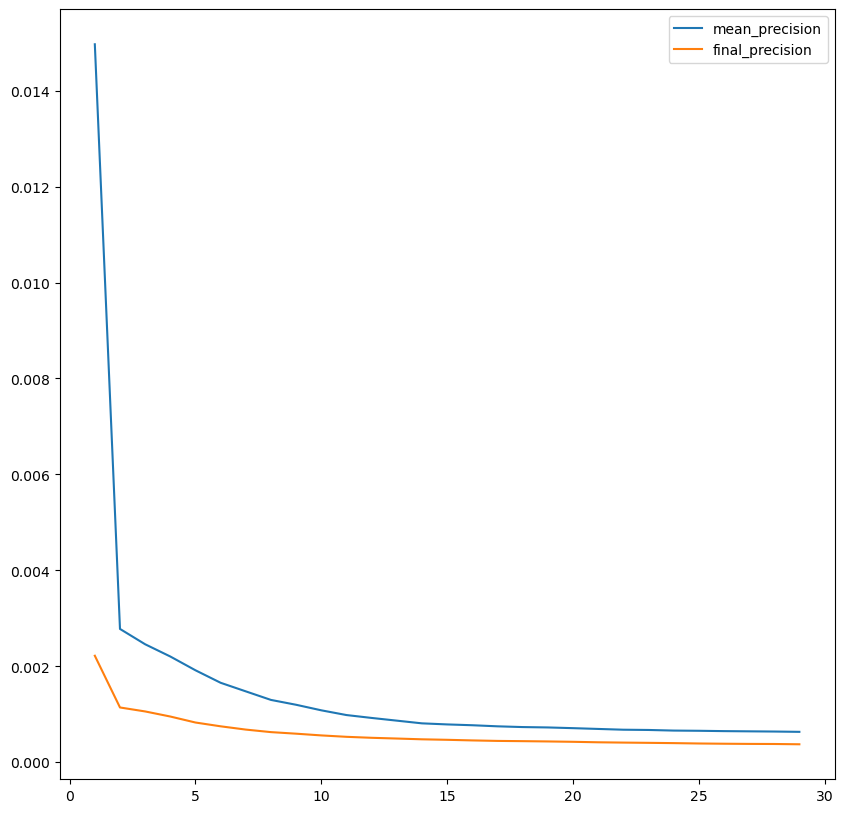

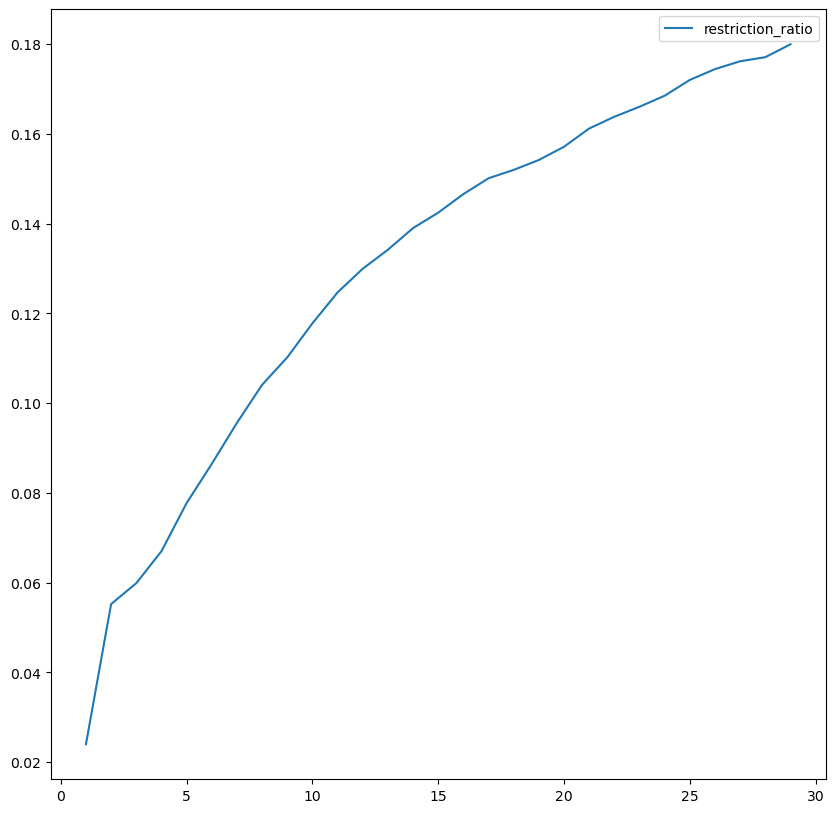

In [6]:
folder = config.resources_path + "model_eval_tree/" + "overshoot_best_in_test/"
cors_arr = np.empty(shape = len(topics), dtype = "object")
for k in range(len(topics)):
    if os.path.isfile(folder + str(k) + ".npy"):
        row_preds = set(list(np.load(folder + str(k) + ".npy")))
    else:
        row_preds = set()
    cors_arr[k] = row_preds

dframe = model_bert_evaluation_helpers.evaluate_quality_from_cors_arr(mapping_dict, data_bert.test_topics_num_id,
                                                                   data_bert.test_contents_num_id, cors_arr)
display(dframe)
dframe[["mean_recall", "final_recall"]].plot(figsize = (10, 10))
plt.show()
dframe[["mean_precision", "final_precision"]].plot(figsize = (10, 10))
plt.show()
dframe[["restriction_ratio"]].plot(figsize = (10, 10))
plt.show()

In [7]:
raise Exception("stopping")
# seems best to pick 7 as the overshoot.
expand = 7
for node in topic_trees:
    compute_expanded_tree(node, expand)
mapping = np.zeros(shape = len(data_bert.topics), dtype=np.int32)
for k in range(len(data_bert.topics)):
    topic_str_id = data_bert.topics.index[k]
    node = total_nodes_by_tid[k]
    mapping[k] = node.least_subtree.topic_num_id

Exception: stopping

In [ ]:
train_stuff_folder = config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_train_eval_train/"
test_stuff_folder = config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_train_eval_test/"

In [ ]:
mfolder = config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_train_eval_train_COMBINE/"

if not os.path.isdir(mfolder):
    os.mkdir(mfolder)

mtopics = []
mcontents = []
saved_files_lengths = []
saved_files = 0

for topic_num_id in data_bert.train_topics_num_id:
    mapped_id = mapping[topic_num_id]
    if os.path.isfile(train_stuff_folder + str(mapped_id) + ".npy"):
        cors = np.load(train_stuff_folder + str(mapped_id) + ".npy")
        mcontents.extend(list(cors))
        mtopics.extend(list(np.repeat(topic_num_id, len(cors))))
        if len(mcontents) > 67108864:
            assert len(mcontents) == len(mtopics)
            np.save(mfolder + str(saved_files) + "_contents.npy", np.array(mcontents, dtype=np.int32))
            np.save(mfolder + str(saved_files) + "_topics.npy", np.array(mtopics, dtype=np.int32))
            saved_files_lengths.append(len(mcontents))
            saved_files += 1
            
            del mtopics, mcontents
            mtopics = []
            mcontents = []

np.save(mfolder + str(saved_files) + "_contents.npy", np.array(mcontents, dtype=np.int32))
np.save(mfolder + str(saved_files) + "_topics.npy", np.array(mtopics, dtype=np.int32))
saved_files_lengths.append(len(mcontents))
saved_files += 1
del mtopics, mcontents
np.save(mfolder + "saved_files_lengths.npy", np.array(saved_files_lengths, dtype=np.int32))

In [ ]:
def check_order(mfolder):
    saved_files_lengths = np.load(mfolder + "saved_files_lengths.npy")

    for file_id in range(len(saved_files_lengths)):
        content_ids = np.load(mfolder + str(file_id) + "_contents.npy")
        topic_ids = np.load(mfolder + str(file_id) + "_topics.npy")
        assert (topic_ids[1:] < topic_ids[:-1]).sum() == 0
        
        for topic_num_id in np.unique(topic_ids):
            left = np.searchsorted(topic_ids, topic_num_id, side="left")
            right = np.searchsorted(topic_ids, topic_num_id, side="right")
            contents_restrict_ids = content_ids[left:right]
            assert (contents_restrict_ids[1:] <= contents_restrict_ids[:-1]).sum() == 0
        
        del content_ids, topic_ids
check_order(config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_train_eval_test_COMBINE/")
check_order(config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_train_eval_train_COMBINE/")

In [ ]:
def check_inclusion(mfolder, train_or_test):
    saved_files_lengths = np.load(mfolder + "saved_files_lengths.npy")

    for file_id in range(len(saved_files_lengths)):
        content_ids = np.load(mfolder + str(file_id) + "_contents.npy")
        topic_ids = np.load(mfolder + str(file_id) + "_topics.npy")
        
        if train_or_test == "train":
            assert (~data_bert.fast_contains_multi(data_bert.train_contents_num_id, content_ids)).sum() == 0
            assert (~data_bert.fast_contains_multi(data_bert.train_topics_num_id, topic_ids)).sum() == 0
        else:
            assert (~data_bert.fast_contains_multi(data_bert.test_contents_num_id, content_ids)).sum() == 0
            assert (~data_bert.fast_contains_multi(data_bert.test_topics_num_id, topic_ids)).sum() == 0
        
        del content_ids, topic_ids
        print(file_id)
check_inclusion(config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_train_eval_test_COMBINE/", "test")
print("done")
check_inclusion(config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_train_eval_train_COMBINE/", "train")

In [ ]:
has_cors_content_ids = []
has_cors_topic_ids = []
def extend_correlations(mfolder):
    saved_files_lengths = np.load(mfolder + "saved_files_lengths.npy")

    for file_id in range(len(saved_files_lengths)):
        content_ids = np.load(mfolder + str(file_id) + "_contents.npy")
        topic_ids = np.load(mfolder + str(file_id) + "_topics.npy")

        contains = data_bert.has_correlations_general(data_bert.has_correlation_contents, data_bert.has_correlation_topics,
                                          content_ids, topic_ids).astype(dtype=np.int32).astype(dtype=bool)

        has_cors_content_ids.extend(list(data_bert.has_correlation_contents[contains]))
        has_cors_topic_ids.extend(list(data_bert.has_correlation_topics[contains]))
        del content_ids, topic_ids

extend_correlations(config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_train_eval_test_COMBINE/")
extend_correlations(config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_train_eval_train_COMBINE/")

In [ ]:
has_cors_topic_ids = np.array(has_cors_topic_ids, dtype=np.int32)
has_cors_content_ids = np.array(has_cors_content_ids, dtype=np.int32)
sidx = np.argsort(has_cors_topic_ids)
has_cors_topic_ids = has_cors_topic_ids[sidx]
has_cors_content_ids = has_cors_content_ids[sidx]

for topic_num_id in np.unique(has_cors_topic_ids):
    left = np.searchsorted(has_cors_topic_ids, topic_num_id, side="left")
    right = np.searchsorted(has_cors_topic_ids, topic_num_id, side="right")
    assert (has_cors_topic_ids[left:right] - has_cors_topic_ids[left]).sum() == 0
    
    sub_contents = has_cors_content_ids[left:right]
    has_cors_content_ids[left:right] = np.sort(sub_contents)

In [ ]:
def check_order_generated(content_ids, topic_ids):
    assert (topic_ids[1:] < topic_ids[:-1]).sum() == 0

    for topic_num_id in np.unique(topic_ids):
        left = np.searchsorted(topic_ids, topic_num_id, side="left")
        right = np.searchsorted(topic_ids, topic_num_id, side="right")
        contents_restrict_ids = content_ids[left:right]
        assert (contents_restrict_ids[1:] <= contents_restrict_ids[:-1]).sum() == 0
check_order_generated(has_cors_content_ids, has_cors_topic_ids)

In [ ]:
np.save(config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_train_cors_topics.npy", has_cors_topic_ids)
np.save(config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_train_cors_contents.npy", has_cors_content_ids)

In [ ]:
mfolder = config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_train_eval_train_COMBINE/"
saved_files_lengths = np.load(mfolder + "saved_files_lengths.npy")
print(saved_files_lengths)

# Check discrepancy

In [ ]:
pred_one_probas = np.load(config.resources_path + "model_eval_tree/" + "PREDICTED_ONE_probas_mnetL12_eng.npy")

In [ ]:
print(len(data_bert.has_correlation_test_topics))
len(pred_one_probas)

In [ ]:
(pred_one_probas > 0.8).sum()

In [ ]:
87288 / 99075

In [ ]:
import os
pred_has_cors_topics = data_bert.has_correlation_test_topics[pred_one_probas > 0.8]
pred_has_cors_contents = data_bert.has_correlation_test_contents[pred_one_probas > 0.8]

for topic_num_id in np.unique(pred_has_cors_topics):
    left = np.searchsorted(pred_has_cors_topics, topic_num_id, side="left")
    right = np.searchsorted(pred_has_cors_topics, topic_num_id, side="right")
    
    pred_direct = pred_has_cors_contents[left:right]
    pred_tree = config.resources_path + "model_eval_tree/" + "precise_best_in_test/" + str(topic_num_id) + ".npy"
    
    if os.path.exists(pred_tree):
        pred_tree = np.load(pred_tree)
    else:
        pred_tree = np.array([], dtype=np.int32)
    
    not_contains = ~data_bert.fast_contains_multi(pred_tree, pred_direct)
    if not_contains.sum() > 0:
        print(topic_num_id, "  ", pred_direct[not_contains])